# Assignment 4 Neural Machine Translation [Team 2]

In [0]:
import os, zipfile, io, requests
URL = 'http://www.manythings.org/anki/deu-eng.zip'
def download_images(url):
    r = requests.get(url, stream=True)
    print ('Downloading ' + url )
    zip_ref = zipfile.ZipFile(io.BytesIO(r.content))
    zip_ref.extractall('./sample_data/deu-eng')
    zip_ref.close()
download_images(URL) #To download

In [0]:
import matplotlib.pyplot as plt
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
def plotAcc(history):  
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

## Load machine translation dataset

In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

## Split document into sentences

In [0]:
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs

## Preprocessing
We perform the following preprocessing steps:-

1. remove all the non-printable characters
2. remove all the punctuation characters
3. normalize all unicode characters to ASCII
4. normalize the case to lowercase
5. remove any tokens that are not alphabetic

In [0]:
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)

In [0]:
%cd sample_data/deu-eng

/content/sample_data/deu-eng


## Viewing clean German-English sentence pairs

In [0]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
filename = 'deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(100):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[go on] => [mach weiter]
[hello] => [hallo]
[i ran] => [ich rannte]
[i see] => [ich verstehe]
[i see] => [aha]
[i try] => [ich probiere es]
[i won] => [ich hab gewonnen]
[i won] => [ich habe gewonnen]
[smile] => [lacheln]
[cheers] => [zum wohl]
[freeze] => [keine bewegung]
[freeze] => [stehenbleiben]
[got it] => [kapiert]
[got it] => [verstanden]
[got it] => [einverstanden]
[he ran] => [er rannte]
[he ran] => [er lief]
[hop in] => [mach mit]
[hug me] => [druck mich]
[hug me] => [nimm mich in den arm]
[hug me] => [umarme mich]
[i fell] => [ich fiel]
[i fell] => [ich fiel hin]
[i fell] => [ich sturzte]
[i fell] => [ich bin hingefallen]
[i fell] => [ich bin gesturzt]
[i know] => [ich wei]
[i lied] => [ich habe gelogen]
[i lost] => [ich habe verloren]
[i paid] => [ich habe bezah

## Splitting dataset into train & test

In [0]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle
 
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')
 
# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [0]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

## Building model

In [0]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM,GRU
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed, Bidirectional
from keras.callbacks import ModelCheckpoint
 
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y
 



Using TensorFlow backend.


In [0]:
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
 
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))
 
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)
 

English Vocabulary Size: 2309
English Max Length: 5
German Vocabulary Size: 3657
German Max Length: 10


## Model 1 Using LSTMs

In [0]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	##encoder
 model = Sequential()
 model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
 model.add(LSTM(n_units))
	##decoder
 model.add(RepeatVector(tar_timesteps))
 model.add(LSTM(n_units, return_sequences=True))
 model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
 return model


# define model
#model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)
# fit model
filename = 'model1.h5'
checkpoint = ModelCheckpoint(filename, verbose=1, save_best_only=True, mode='min')
history1 = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 256)           936192    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 2309)           593413    
Total params: 2,580,229
Trainable params: 2,580,229
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train o

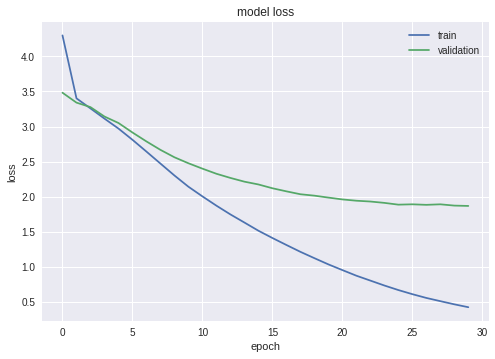

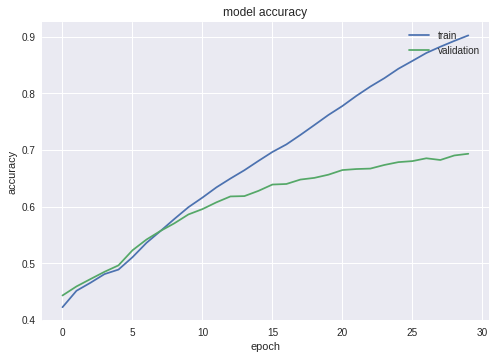

In [0]:
plotLosses(history1)
plotAcc(history1)

## Model 2 Using Bi-directional LSTMs

In [0]:
def define_model_2(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
##encoder
 model = Sequential()
 model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
 model.add(Bidirectional(LSTM(n_units)))
#decoder
 model.add(RepeatVector(tar_timesteps))
 model.add(Bidirectional(LSTM(n_units, return_sequences=True)))
 model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
 return model

In [0]:
# define model
#model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model = define_model_2(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)
# fit model
filename = 'model2.h5'
checkpoint = ModelCheckpoint(filename, verbose=1, save_best_only=True, mode='min')
history2=model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=1)


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 256)           936192    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1050624   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 512)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 5, 512)            1574912   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 2309)           1184517   
Total params: 4,746,245
Trainable params: 4,746,245
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train o

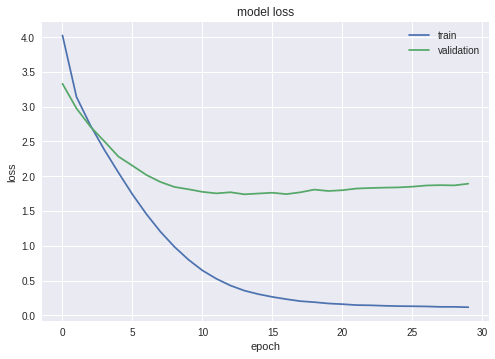

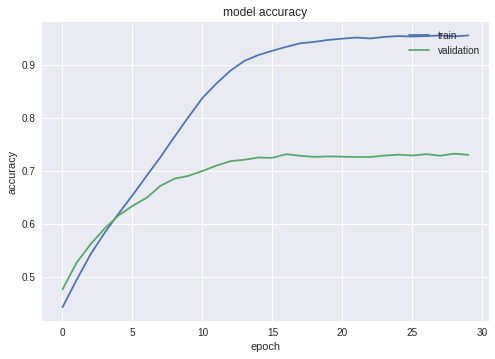

In [0]:
plotLosses(history2)
plotAcc(history2)

## Model 3 Using GRU

In [0]:
def define_model_3(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	##encoder
 model = Sequential()
 model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
 model.add(GRU(n_units))
	##decoder
 model.add(RepeatVector(tar_timesteps))
 model.add(GRU(n_units, return_sequences=True))
 model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
 return model

In [0]:
# define model
#model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model = define_model_3(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)
# fit model
filename = 'model3.h5'
checkpoint = ModelCheckpoint(filename, verbose=1, save_best_only=True, mode='min')
history3=model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 10, 256)           936192    
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               393984    
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 5, 256)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 5, 256)            393984    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 5, 2309)           593413    
Total params: 2,317,573
Trainable params: 2,317,573
Non-trainable params: 0
_________________________________________________________________
None
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 12s 1ms/step - loss: 4.

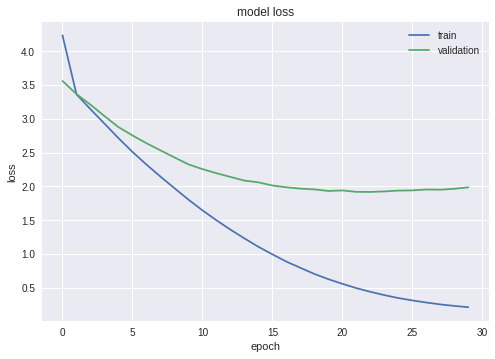

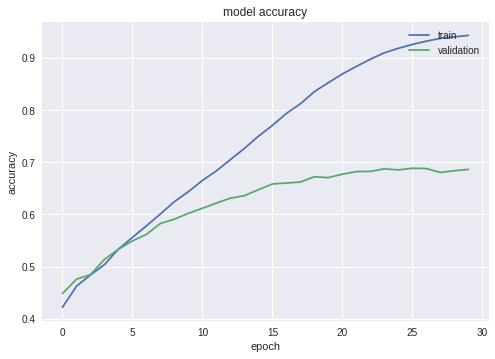

In [0]:
plotLosses(history3)
plotAcc(history3)

## Model 4 Using Bidirectional GRUs

In [0]:
def define_model_4(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	##encoder
 model = Sequential()
 model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
 model.add(Bidirectional(GRU(n_units)))
	##decoder
 model.add(RepeatVector(tar_timesteps))
 model.add(Bidirectional(GRU(n_units, return_sequences=True)))
 model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
 return model

In [0]:
# define model
#model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model = define_model_4(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)
# fit model
filename = 'model4.h5'
checkpoint = ModelCheckpoint(filename, verbose=1, save_best_only=True, mode='min')
history4=model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 256)           936192    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               787968    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 5, 512)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 5, 512)            1181184   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 2309)           1184517   
Total params: 4,089,861
Trainable params: 4,089,861
Non-trainable params: 0
_________________________________________________________________
None
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 22s 2ms/step - loss: 3.

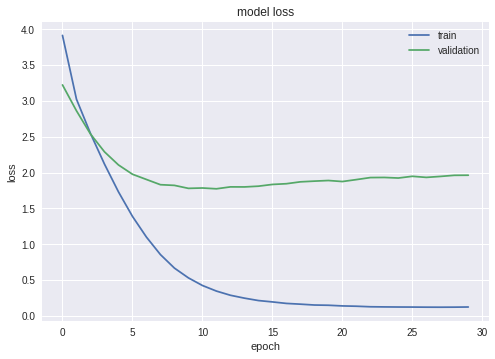

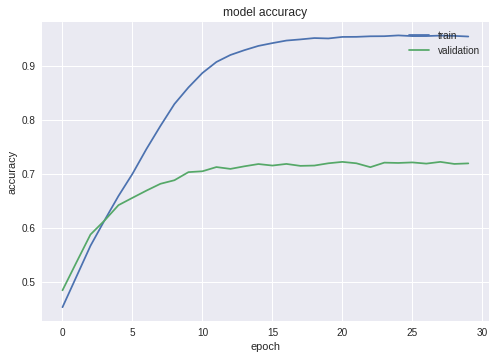

In [0]:
plotLosses(history4)
plotAcc(history4)

## Model 5 Using stacked LSTMS

In [0]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	##encoder
 model = Sequential()
 model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
 model.add(LSTM(n_units,return_sequences = True))
 model.add(LSTM(n_units,return_sequences = True))
 model.add(LSTM(n_units,return_sequences = True))
 model.add(LSTM(n_units))
	##decoder
 model.add(RepeatVector(tar_timesteps))
 model.add(LSTM(n_units,return_sequences = True))
 model.add(LSTM(n_units,return_sequences = True))
 model.add(LSTM(n_units,return_sequences = True))
 model.add(LSTM(n_units, return_sequences=True))
 model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
 return model


# define model
#model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)
# fit model
filename = 'model5.h5'
checkpoint = ModelCheckpoint(filename, verbose=1, save_best_only=True, mode='min')
history5 = model.fit(trainX, trainY, epochs=60, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 10, 256)           936192    
_________________________________________________________________
lstm_21 (LSTM)               (None, 10, 256)           525312    
_________________________________________________________________
lstm_22 (LSTM)               (None, 10, 256)           525312    
_________________________________________________________________
lstm_23 (LSTM)               (None, 10, 256)           525312    
_________________________________________________________________
lstm_24 (LSTM)               (None, 256)               525312    
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 5, 256)            525312    
__________

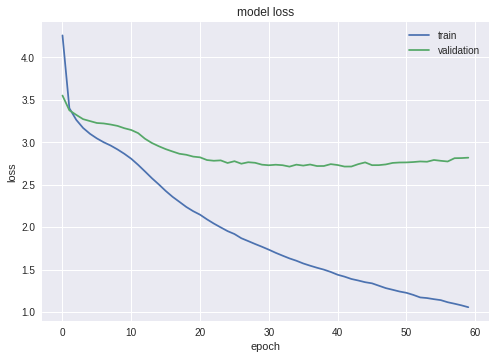

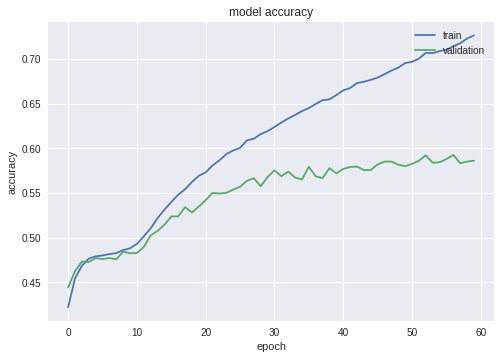

In [0]:
plotLosses(history5)
plotAcc(history5)

## Evaluation

In [0]:
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
 
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)
 
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append(raw_target.split())
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
 
# load model
model = load_model('model2.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[tom ist gut gelaunt], target=[toms cheerful], predicted=[toms cheerful]
src=[tom hat dich gebraucht], target=[tom needed you], predicted=[tom needed you]
src=[mir wird hei], target=[im getting hot], predicted=[im getting hot]
src=[sie ist nicht gro], target=[she is not tall], predicted=[she is tall]
src=[es bringt nichts], target=[its no use], predicted=[its no use]
src=[dreh nicht durch], target=[dont freak out], predicted=[dont freak up]
src=[ein fisch kann schwimmen], target=[a fish can swim], predicted=[a a fish]
src=[japan ist eigenartig], target=[japan is weird], predicted=[japan is weird]
src=[ich werde es fur mich behalten], target=[mums the word], predicted=[mums word word]
src=[das war laut], target=[that was loud], predicted=[that was loud]


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.078686
BLEU-2: 0.270987
BLEU-3: 0.444395
BLEU-4: 0.502892
test
src=[du verlierst], target=[youre losing], predicted=[you are]
src=[tom hat mich sitzenlassen], target=[tom dumped me], predicted=[tom dumped me]
src=[tom ist gestolpert], target=[tom tripped], predicted=[tom is]
src=[er hat mich getauscht], target=[he deceived me], predicted=[he dumped me]
src=[wir haben geschlossen], target=[were closed], predicted=[we need guests]
src=[entschuldigt euch einfach], target=[just apologize], predicted=[just check it]
src=[ich muss lernen], target=[i must study], predicted=[i have to study]
src=[tom ist verargert], target=[tom is angry], predicted=[tom is upset]
src=[ich habe tom geholfen], target=[i helped tom], predicted=[i helped tom]
src=[lasst mich sehen], target=[let me see that], predicted=[let me see]
BLEU-1: 0.080546
BLEU-2: 0.272974
BLEU-3: 0.444789
BLEU-4: 0.502529


## Basic NMT chatbot

In [0]:

from nltk.translate.bleu_score import sentence_bleu
model = load_model('model2.h5')

# evaluate the skill of the model
def evaluate_model_translate(model, tokenizer, source, raw_dataset):
 actual, predicted = list(), list()
 
		# translate encoded source text
 source = source.reshape((1, source.shape[0]))
 translation = predict_sequence(model, eng_tokenizer, source)
 raw_target, raw_src = raw_dataset[:,0],raw_dataset[:,1]
 print(raw_target[0])
 print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
 #for each in raw_target:
 # actual.append(each)
 actual.append(raw_src[0].split())
 predicted.append(translation.split())
	# calculate BLEU score
 #print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
 #print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
 #print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
 #print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 
 pred_flat = sum(predicted, [])
 #print(pred_flat)
 #print(np.asarray(pred_flat).shape)
 #print(predicted)
 #print(np.asarray(predicted).shape)
 bleu_score = sentence_bleu(actual,pred_flat)
 print('BLEU: %f' % bleu_score)
 return translation,bleu_score

 #print(actual)
 #print(np.asarray(actual).shape)
 #print(translation)





In [0]:
import numpy as np

sentence_list = []
translation_list = []
prediction_list = []
score_list = []

k=0
while(k==0):
 
 sentence = input("\n\nPress 1 to quit\nEnter Sentence\n")
 if(sentence == '1'):
  break
 else:
  translation = input("Enter Real Translation\n")
  dt = np.dtype('<U370') 
  sent_trans = np.array([(sentence,translation)], dtype=dt)
  enc_sent = encode_sequences(ger_tokenizer, ger_length, sent_trans[:,0])
  final_enc_sent = enc_sent.flatten()
  pred_trans,b_score = evaluate_model_translate(model, eng_tokenizer, final_enc_sent, sent_trans)
  sentence_list.append(sentence)
  translation_list.append(translation)
  prediction_list.append(pred_trans)
  score_list.append(b_score)
  
  




Press 1 to quit
Enter Sentence
wer bist du
Enter Real Translation
where are you


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


wer bist du
src=[['where are you']], target=[['wer bist du']], predicted=[whos are]
BLEU: 0.510029


Press 1 to quit
Enter Sentence
ich komme
Enter Real Translation
i am coming
ich komme
src=[['i am coming']], target=[['ich komme']], predicted=[im going]
BLEU: 0.000000


Press 1 to quit
Enter Sentence
er weinte
Enter Real Translation
he was crying


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


er weinte
src=[['he was crying']], target=[['er weinte']], predicted=[he was crying]
BLEU: 1.000000


Press 1 to quit
Enter Sentence
Ich bin gelangweilt
Enter Real Translation
im bored


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Ich bin gelangweilt
src=[['im bored']], target=[['Ich bin gelangweilt']], predicted=[im bored]
BLEU: 1.000000


Press 1 to quit
Enter Sentence
Komm zu meinem Haus
Enter Real Translation
come to my house
Komm zu meinem Haus
src=[['come to my house']], target=[['Komm zu meinem Haus']], predicted=[get get move]
BLEU: 0.000000


Press 1 to quit
Enter Sentence
mein Auto ist kaputt
Enter Real Translation
my car is broken
mein Auto ist kaputt
src=[['my car is broken']], target=[['mein Auto ist kaputt']], predicted=[my my is]
BLEU: 0.647459


Press 1 to quit
Enter Sentence
Ich habe mir die Nase gebrochen
Enter Real Translation
i broke my nose
Ich habe mir die Nase gebrochen
src=[['i broke my nose']], target=[['Ich habe mir die Nase gebrochen']], predicted=[i the the leg]
BLEU: 0.707107


Press 1 to quit
Enter Sentence
Triff mich morgen
Enter Real Translation
meet me tomorrow
Triff mich morgen
src=[['meet me tomorrow']], target=[['Triff mich morgen']], predicted=[trust tomorrow]
BLEU: 0.510029


In [0]:
import pandas as pd
results_df = pd.DataFrame(
    {'German_Sentence': sentence_list,
     'Real_Translation': translation_list,
     'Predicted_Translation': prediction_list,
     'BLEU_Score':score_list
    })


In [0]:
results_df

,BLEU_Score,German_Sentence,Predicted_Translation,Real_Translation
0,0.510029,wer bist du,whos are,where are you
1,0.000000,ich komme,im going,i am coming
2,1.000000,er weinte,he was crying,he was crying
3,1.000000,Ich bin gelangweilt,im bored,im bored
4,0.000000,Komm zu meinem Haus,get get move,come to my house
5,0.647459,mein Auto ist kaputt,my my is,my car is broken
6,0.707107,Ich habe mir die Nase gebrochen,i the the leg,i broke my nose
7,0.510029,Triff mich morgen,trust tomorrow,meet me tomorrow
8,0.544446,Ich habe es vergessen,i burned burned,i forgot about it
9,0.000000,die katze ist gestorben,his all pretty,the cat died
